In [4]:
import warnings
from itertools import product

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import (StratifiedKFold, KFold,
                                     cross_val_score, train_test_split)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=Warning)

N_SPLITS = 2
RANDOM_STATE = 148260

In [5]:
def CalculateMorganFingerprint(mol):
    mfpgen = AllChem.GetMorganGenerator(radius=2,fpSize=2048)
    fingerprint = np.array([mfpgen.GetFingerprintAsNumPy(x) for x in mol])
    fingerprint = pd.DataFrame(fingerprint, columns = ['mfp'+str(i) for i in range(fingerprint.shape[1])])
    return fingerprint

In [6]:
def CalculateDescriptors(mol):
    calc = Calculator(descriptors, ignore_3D=False)
    X_mordred = calc.pandas(mol, nproc=1)
    X_mordred = X_mordred.select_dtypes(['number'])
    #normalize
    X_mordred = (X_mordred-X_mordred.min())/(X_mordred.max()-X_mordred.min())
    #drop columns wth low std
    X_mordred = X_mordred.loc[:,X_mordred.std()>0.01]
    return X_mordred

In [7]:
def LoadDatasetCSV(path, threshold=7.0, regression = False):
    df = pd.read_csv(path)
    df['molecule_from_smiles'] = df['smiles'].apply(Chem.MolFromSmiles)
    df['smiles'] = df['smiles'].map(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
    df.drop_duplicates('smiles')
    df = df.dropna()
    if regression:
        df['Target'] = df['pIC50']
    else:
        df['Target'] = df['pIC50'] > threshold
    return df

In [8]:
def split_data(df, approach = 'desc', split = 0.7):
    #TODO: support for different approaches - if applicable
    if approach == 'desc':
        X = CalculateDescriptors(df['molecule_from_smiles'])
    else:
        X = CalculateMorganFingerprint(df['molecule_from_smiles'])
    y = df["Target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-split), random_state=42)
    return X_train, y_train, X_test, y_test

In [9]:
data_classification = LoadDatasetCSV("data\processed\simple_input_data.csv")
data_classification.head()

,smiles,pIC50,molecule_from_smiles,Target
0,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...,9.154901,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E3...,True
1,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...,8.853872,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E3...,True
2,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E3...,True
3,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E3...,True
4,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E3...,True


In [10]:
data_regression = LoadDatasetCSV("data\processed\simple_input_data.csv", regression=True)
data_regression.head()

,smiles,pIC50,molecule_from_smiles,Target
0,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...,9.154901,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,9.154901
1,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...,8.853872,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,8.853872
2,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,8.698970
3,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,8.698970
4,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,8.698970


In [11]:
X_train_desc_classification, y_train_desc_classification, X_test_desc_classification, y_test_desc_classification = split_data(data_classification)

100%|██████████| 1519/1519 [17:00<00:00,  1.49it/s]


In [12]:
X_train_desc_regression, y_train_desc_regression, X_test_desc_regression, y_test_desc_regression = split_data(data_regression)

100%|██████████| 1519/1519 [15:53<00:00,  1.59it/s] 


In [13]:
X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification = split_data(data_classification, approach = 'fp')

In [14]:
X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression = split_data(data_regression, approach = 'fp')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [57]:
top_1_cls = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1)
top_2_cls = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=2)
top_3_cls = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=2)
top_4_cls = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5, min_samples_leaf=2)
top_5_cls= GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

In [63]:
top_1_cls.fit(X_train_desc_classification, y_train_desc_classification)
y_pred = top_1_cls.predict(X_test_desc_classification)
accuracy = accuracy_score(y_test_desc_classification, y_pred)
print(f"accuracy: {accuracy}")
cls_rep = classification_report(y_test_desc_classification, y_pred)
print(cls_rep)
wrong_top1 = X_test_desc_classification[y_test_desc_classification != y_pred].index
print(list(wrong_top1))

accuracy: 0.8267543859649122
              precision    recall  f1-score   support

       False       0.84      0.85      0.85       260
        True       0.80      0.79      0.80       196

    accuracy                           0.83       456
   macro avg       0.82      0.82      0.82       456
weighted avg       0.83      0.83      0.83       456

[1240, 634, 99, 453, 141, 808, 70, 764, 727, 1272, 220, 29, 1079, 817, 868, 1318, 59, 782, 1054, 787, 78, 720, 534, 351, 834, 589, 420, 43, 107, 714, 677, 429, 1007, 818, 916, 1091, 941, 983, 218, 56, 1024, 785, 1036, 678, 438, 812, 1179, 1073, 607, 58, 1225, 81, 847, 882, 859, 86, 1342, 113, 631, 1001, 285, 31, 826, 918, 915, 83, 1245, 528, 1263, 526, 346, 715, 879, 781, 54, 997, 963, 744, 1418]


In [64]:
top_2_cls.fit(X_train_desc_classification, y_train_desc_classification)
y_pred = top_2_cls.predict(X_test_desc_classification)
accuracy = accuracy_score(y_test_desc_classification, y_pred)
print(f"accuracy: {accuracy}")
cls_rep = classification_report(y_test_desc_classification, y_pred)
print(cls_rep)
wrong_top2 = X_test_desc_classification[y_test_desc_classification != y_pred].index
print(list(wrong_top2))

accuracy: 0.8223684210526315
              precision    recall  f1-score   support

       False       0.85      0.84      0.84       260
        True       0.79      0.80      0.79       196

    accuracy                           0.82       456
   macro avg       0.82      0.82      0.82       456
weighted avg       0.82      0.82      0.82       456

[1240, 99, 453, 141, 808, 70, 914, 764, 727, 1272, 220, 29, 817, 868, 1318, 59, 782, 1054, 787, 78, 534, 351, 834, 589, 107, 714, 677, 429, 1007, 818, 916, 1091, 941, 983, 218, 56, 1024, 785, 1036, 678, 433, 438, 812, 986, 1179, 1073, 607, 58, 1225, 552, 718, 81, 1080, 847, 882, 682, 859, 86, 1342, 113, 631, 1001, 285, 31, 826, 918, 915, 83, 1245, 1263, 346, 715, 879, 781, 909, 54, 1338, 997, 963, 744, 1418]


In [65]:
top_3_cls.fit(X_train_desc_classification, y_train_desc_classification)
y_pred = top_3_cls.predict(X_test_desc_classification)
accuracy = accuracy_score(y_test_desc_classification, y_pred)
print(f"accuracy: {accuracy}")
cls_rep = classification_report(y_test_desc_classification, y_pred)
print(cls_rep)
wrong_top3 = X_test_desc_classification[y_test_desc_classification != y_pred].index
print(list(wrong_top3))

accuracy: 0.8179824561403509
              precision    recall  f1-score   support

       False       0.84      0.84      0.84       260
        True       0.79      0.79      0.79       196

    accuracy                           0.82       456
   macro avg       0.81      0.81      0.81       456
weighted avg       0.82      0.82      0.82       456

[1240, 99, 453, 141, 808, 70, 914, 67, 764, 727, 1272, 220, 29, 1079, 817, 868, 1318, 59, 782, 1054, 787, 78, 534, 351, 834, 589, 420, 43, 107, 714, 677, 429, 1007, 818, 916, 1091, 941, 983, 218, 56, 1024, 785, 1036, 678, 438, 812, 986, 1179, 1073, 607, 58, 1225, 552, 718, 81, 847, 882, 682, 859, 86, 1342, 113, 631, 1001, 285, 31, 826, 915, 83, 1245, 528, 1263, 346, 715, 879, 781, 846, 54, 1338, 997, 963, 744, 1418]


In [66]:
top_4_cls.fit(X_train_desc_classification, y_train_desc_classification)
y_pred = top_4_cls.predict(X_test_desc_classification)
accuracy = accuracy_score(y_test_desc_classification, y_pred)
print(f"accuracy: {accuracy}")
cls_rep = classification_report(y_test_desc_classification, y_pred)
print(cls_rep)
wrong_top4 = X_test_desc_classification[y_test_desc_classification != y_pred].index
print(list(wrong_top4))

accuracy: 0.8267543859649122
              precision    recall  f1-score   support

       False       0.85      0.84      0.85       260
        True       0.79      0.81      0.80       196

    accuracy                           0.83       456
   macro avg       0.82      0.82      0.82       456
weighted avg       0.83      0.83      0.83       456

[1240, 99, 453, 141, 808, 70, 764, 727, 970, 1272, 220, 29, 817, 868, 1318, 59, 782, 1054, 787, 78, 534, 351, 834, 589, 107, 677, 429, 1007, 818, 916, 1091, 486, 941, 983, 218, 30, 56, 1024, 785, 1036, 678, 438, 812, 986, 1179, 1073, 607, 58, 1225, 552, 81, 1125, 847, 882, 859, 86, 1342, 113, 631, 1001, 285, 31, 826, 918, 915, 83, 1245, 1263, 526, 346, 715, 879, 781, 909, 846, 997, 963, 744, 1418]


In [67]:
top_5_cls.fit(X_train_desc_classification, y_train_desc_classification)
y_pred = top_5_cls.predict(X_test_desc_classification)
accuracy = accuracy_score(y_test_desc_classification, y_pred)
print(f"accuracy: {accuracy}")
cls_rep = classification_report(y_test_desc_classification, y_pred)
print(cls_rep)
wrong_top5 = X_test_desc_classification[y_test_desc_classification != y_pred].index
print(list(wrong_top5))

accuracy: 0.8135964912280702
              precision    recall  f1-score   support

       False       0.84      0.83      0.83       260
        True       0.78      0.80      0.79       196

    accuracy                           0.81       456
   macro avg       0.81      0.81      0.81       456
weighted avg       0.81      0.81      0.81       456

[1240, 634, 99, 453, 141, 808, 70, 914, 764, 727, 1272, 220, 29, 817, 868, 1318, 59, 782, 1054, 787, 78, 534, 788, 351, 746, 834, 589, 420, 43, 107, 820, 677, 429, 1007, 818, 916, 1091, 486, 941, 983, 56, 1024, 785, 678, 812, 986, 1179, 1073, 607, 618, 58, 1225, 552, 978, 718, 81, 1080, 1325, 847, 882, 859, 86, 1342, 113, 631, 1001, 285, 31, 826, 918, 915, 83, 1245, 1263, 526, 346, 715, 879, 781, 846, 1338, 997, 963, 744, 1418]


In [73]:
def func_diff(m1, m2):
    print(len(m1))
    print(len(m2))
    print(set(m1) - set(m2))
    print(set(m2) - set(m1))

In [81]:
from collections import Counter

all_wrong_elements = list(wrong_top1) + list(wrong_top2) + list(wrong_top3) + list(wrong_top4) + list(wrong_top5)

counts = Counter(all_wrong_elements)

In [93]:
for element, count in dict(counts).items():
    print(f"{element} : {count}")

1240 : 5
634 : 2
99 : 5
453 : 5
141 : 5
808 : 5
70 : 5
764 : 5
727 : 5
1272 : 5
220 : 5
29 : 5
1079 : 2
817 : 5
868 : 5
1318 : 5
59 : 5
782 : 5
1054 : 5
787 : 5
78 : 5
720 : 1
534 : 5
351 : 5
834 : 5
589 : 5
420 : 3
43 : 3
107 : 5
714 : 3
677 : 5
429 : 5
1007 : 5
818 : 5
916 : 5
1091 : 5
941 : 5
983 : 5
218 : 4
56 : 5
1024 : 5
785 : 5
1036 : 4
678 : 5
438 : 4
812 : 5
1179 : 5
1073 : 5
607 : 5
58 : 5
1225 : 5
81 : 5
847 : 5
882 : 5
859 : 5
86 : 5
1342 : 5
113 : 5
631 : 5
1001 : 5
285 : 5
31 : 5
826 : 5
918 : 4
915 : 5
83 : 5
1245 : 5
528 : 2
1263 : 5
526 : 3
346 : 5
715 : 5
879 : 5
781 : 5
54 : 3
997 : 5
963 : 5
744 : 5
1418 : 5
914 : 3
433 : 1
986 : 4
552 : 4
718 : 3
1080 : 2
682 : 2
909 : 2
1338 : 3
67 : 1
846 : 3
970 : 1
486 : 2
30 : 1
1125 : 1
788 : 1
746 : 1
820 : 1
618 : 1
978 : 1
1325 : 1


In [99]:
filtered_counts = {element for element, count in counts.items() if count == 5}

In [104]:
data_regression.iloc[list(filtered_counts)]['Target']

1024    6.221849
1418    4.522879
141     6.110138
782     7.026872
781     7.031517
          ...   
882     6.721246
879     6.721246
631     7.376751
1272    5.283997
764     7.055517
Name: Target, Length: 66, dtype: float64

In [105]:
data_classification.iloc[list(filtered_counts)]['Target']

1024    False
1418    False
141     False
782      True
781      True
        ...  
882     False
879     False
631      True
1272    False
764      True
Name: Target, Length: 66, dtype: bool

In [111]:
list(abs(7 - (data_regression.iloc[list(filtered_counts)]['Target'])))

1024    0.778151
1418    2.477121
141     0.889862
782     0.026872
781     0.031517
          ...   
882     0.278754
879     0.278754
631     0.376751
1272    1.716003
764     0.055517
Name: Target, Length: 66, dtype: float64

(array([10.,  7.,  4.,  7.,  4.,  3.,  5.,  1.,  4.,  2.,  2.,  3.,  3.,
         1.,  0.,  1.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.004365  , 0.08679021, 0.16921543, 0.25164064, 0.33406585,
        0.41649107, 0.49891628, 0.58134149, 0.66376671, 0.74619192,
        0.82861713, 0.91104235, 0.99346756, 1.07589277, 1.15831799,
        1.2407432 , 1.32316841, 1.40559363, 1.48801884, 1.57044405,
        1.65286927, 1.73529448, 1.81771969, 1.90014491, 1.98257012,
        2.06499533, 2.14742055, 2.22984576, 2.31227097, 2.39469619,
        2.4771214 ]),
 <BarContainer object of 30 artists>)

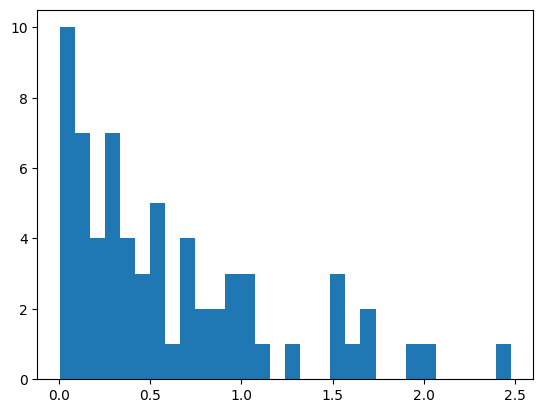

In [114]:
plt.hist(list(abs(7 - (data_regression.iloc[list(filtered_counts)]['Target']))), bins=30)

(array([5., 2., 0., 2., 1., 3., 2., 1., 0., 3., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.0132284 , 0.09908185, 0.1849353 , 0.27078875, 0.3566422 ,
        0.44249565, 0.5283491 , 0.61420255, 0.700056  , 0.78590945,
        0.8717629 , 0.95761635, 1.0434698 , 1.12932325, 1.2151767 ,
        1.30103015, 1.3868836 , 1.47273705, 1.5585905 , 1.64444395,
        1.7302974 , 1.81615085, 1.9020043 , 1.98785775, 2.0737112 ,
        2.15956465, 2.2454181 , 2.33127155, 2.417125  , 2.50297845,
        2.5888319 ]),
 <BarContainer object of 30 artists>)

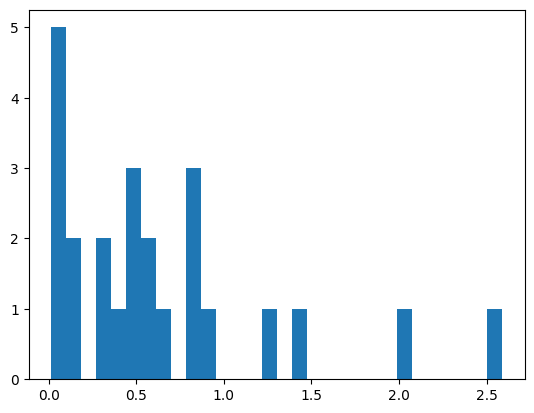

In [121]:
cnt = 1

plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items() if count == cnt})]['Target']))), bins=30)

(array([2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.1051302 , 0.16708546, 0.22904072, 0.29099598, 0.35295124,
        0.4149065 , 0.47686176, 0.53881702, 0.60077228, 0.66272754,
        0.7246828 , 0.78663806, 0.84859332, 0.91054858, 0.97250384,
        1.0344591 , 1.09641436, 1.15836962, 1.22032488, 1.28228014,
        1.3442354 , 1.40619066, 1.46814592, 1.53010118, 1.59205644,
        1.6540117 , 1.71596696, 1.77792222, 1.83987748, 1.90183274,
        1.963788  ]),
 <BarContainer object of 30 artists>)

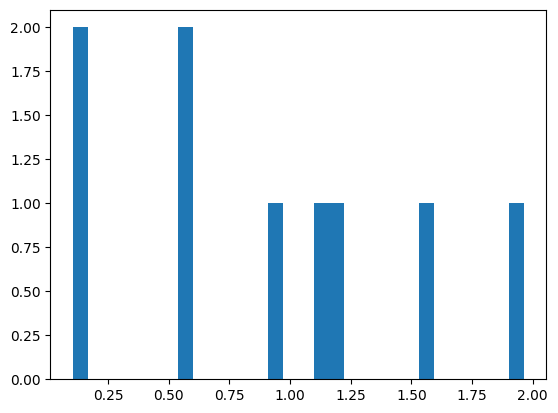

In [122]:
cnt = 2

plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items() if count == cnt})]['Target']))), bins=30)

(array([2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.0500002 , 0.08546498, 0.12092976, 0.15639454, 0.19185932,
        0.2273241 , 0.26278888, 0.29825366, 0.33371844, 0.36918322,
        0.404648  , 0.44011278, 0.47557756, 0.51104234, 0.54650712,
        0.5819719 , 0.61743668, 0.65290146, 0.68836624, 0.72383102,
        0.7592958 , 0.79476058, 0.83022536, 0.86569014, 0.90115492,
        0.9366197 , 0.97208448, 1.00754926, 1.04301404, 1.07847882,
        1.1139436 ]),
 <BarContainer object of 30 artists>)

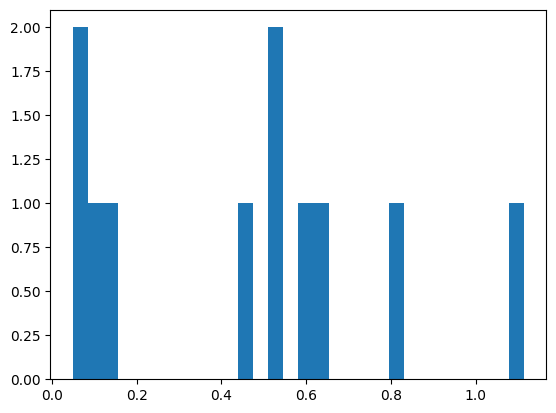

In [123]:
cnt = 3

plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items() if count == cnt})]['Target']))), bins=30)

(array([1., 1., 1., 0., 4., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.0087738 , 0.06381189, 0.11884997, 0.17388806, 0.22892615,
        0.28396423, 0.33900232, 0.39404041, 0.44907849, 0.50411658,
        0.55915467, 0.61419275, 0.66923084, 0.72426893, 0.77930701,
        0.8343451 , 0.88938319, 0.94442127, 0.99945936, 1.05449745,
        1.10953553, 1.16457362, 1.21961171, 1.27464979, 1.32968788,
        1.38472597, 1.43976405, 1.49480214, 1.54984023, 1.60487831,
        1.6599164 ]),
 <BarContainer object of 30 artists>)

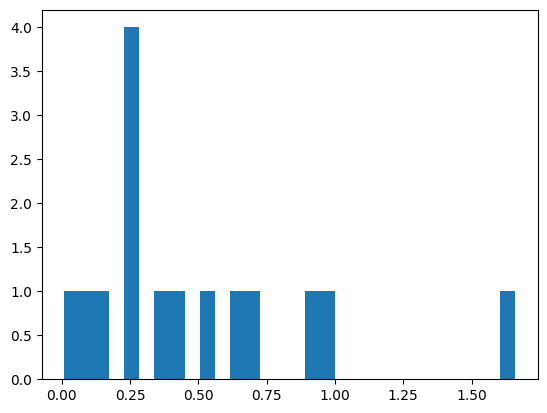

In [124]:
cnt = 4

plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items() if count == cnt})]['Target']))), bins=30)

(array([7., 8., 3., 6., 5., 1., 3., 2., 3., 4., 2., 4., 4., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1.]),
 array([0.004365  , 0.08679021, 0.16921543, 0.25164064, 0.33406585,
        0.41649107, 0.49891628, 0.58134149, 0.66376671, 0.74619192,
        0.82861713, 0.91104235, 0.99346756, 1.07589277, 1.15831799,
        1.2407432 , 1.32316841, 1.40559363, 1.48801884, 1.57044405,
        1.65286927, 1.73529448, 1.81771969, 1.90014491, 1.98257012,
        2.06499533, 2.14742055, 2.22984576, 2.31227097, 2.39469619,
        2.4771214 ]),
 <BarContainer object of 30 artists>)

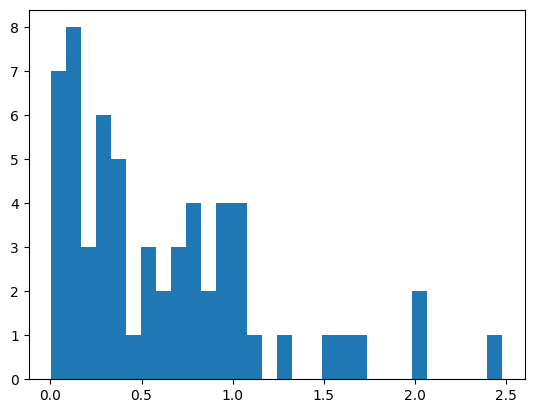

In [127]:
cnt = 5

plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items() if count == cnt})]['Target']))), bins=30)

(array([13., 18.,  8.,  7.,  9.,  2., 13.,  6.,  4.,  8.,  4.,  7.,  5.,
         1.,  1.,  1.,  1.,  1.,  2.,  2.,  0.,  0.,  1.,  3.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([0.004365  , 0.0905139 , 0.17666279, 0.26281169, 0.34896059,
        0.43510948, 0.52125838, 0.60740728, 0.69355617, 0.77970507,
        0.86585397, 0.95200286, 1.03815176, 1.12430066, 1.21044955,
        1.29659845, 1.38274735, 1.46889624, 1.55504514, 1.64119404,
        1.72734293, 1.81349183, 1.89964073, 1.98578962, 2.07193852,
        2.15808742, 2.24423631, 2.33038521, 2.41653411, 2.502683  ,
        2.5888319 ]),
 <BarContainer object of 30 artists>)

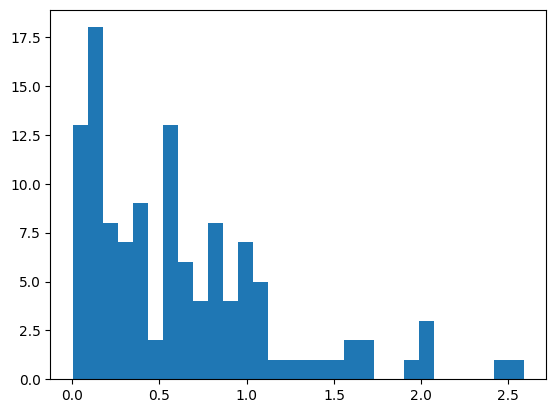

In [128]:
plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items()})]['Target']))), bins=30)

In [115]:
def func_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy: {accuracy}")
    cls_rep = classification_report(y_test, y_pred)
    print(cls_rep)
    wrong_elements = X_test_desc_classification[y_test != y_pred].index
    print(list(wrong_elements))
    return wrong_elements

In [116]:
top_1_cls = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1)
top_2_cls = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=2)
top_3_cls = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=2)
top_4_cls = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5, min_samples_leaf=2)
top_5_cls= GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

In [117]:
wrong_fp_1 = func_model(top_1_cls, X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification)
wrong_fp_2 = func_model(top_2_cls, X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification)
wrong_fp_3 = func_model(top_3_cls, X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification)
wrong_fp_4 = func_model(top_4_cls, X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification)
wrong_fp_5 = func_model(top_5_cls, X_train_fp_classification, y_train_fp_classification, X_test_fp_classification, y_test_fp_classification)

accuracy: 0.8289473684210527
              precision    recall  f1-score   support

       False       0.85      0.85      0.85       260
        True       0.80      0.80      0.80       196

    accuracy                           0.83       456
   macro avg       0.83      0.83      0.83       456
weighted avg       0.83      0.83      0.83       456

[1084, 453, 141, 724, 560, 808, 70, 1124, 764, 727, 1272, 220, 29, 428, 1079, 817, 868, 1318, 59, 839, 23, 115, 1054, 787, 78, 745, 351, 834, 420, 714, 677, 429, 1007, 818, 916, 1091, 983, 30, 56, 1024, 678, 438, 812, 986, 1179, 1073, 607, 618, 58, 81, 111, 847, 882, 859, 86, 1342, 543, 113, 285, 31, 743, 826, 918, 915, 83, 1245, 526, 346, 715, 781, 909, 846, 1338, 997, 963, 744, 741, 1418]
accuracy: 0.7894736842105263
              precision    recall  f1-score   support

       False       0.79      0.86      0.82       260
        True       0.79      0.69      0.74       196

    accuracy                           0.79       456
   

In [130]:
from collections import Counter

all_wrong_elements = list(wrong_fp_1) + list(wrong_fp_2) + list(wrong_fp_3) + list(wrong_fp_4) + list(wrong_fp_5)

counts_fp = Counter(all_wrong_elements)

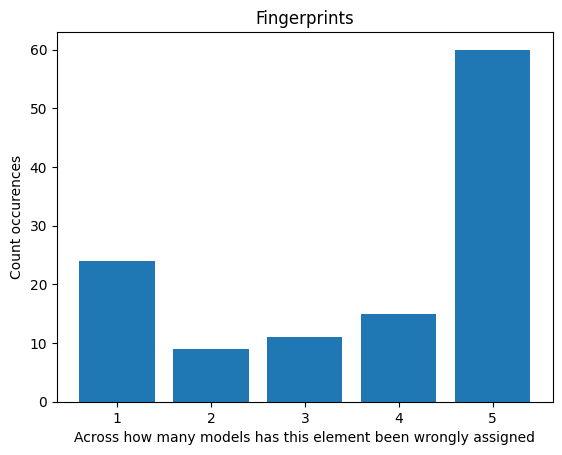

In [131]:
counts2_fp = Counter(dict(counts_fp).values())
keys = list(dict(counts2_fp).keys())
values = list(dict(counts2_fp).values())

plt.bar(keys, values)
plt.xlabel('Across how many models has this element been wrongly assigned')
plt.ylabel('Count occurences')
plt.title('Fingerprints')
plt.show()

(array([39., 18., 23., 19.,  7.,  3.,  4.,  4.,  0.,  2.]),
 array([0.004365  , 0.26281169, 0.52125838, 0.77970507, 1.03815176,
        1.29659845, 1.55504514, 1.81349183, 2.07193852, 2.33038521,
        2.5888319 ]),
 <BarContainer object of 10 artists>)

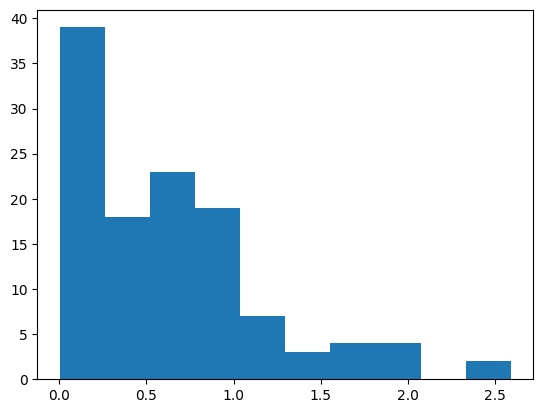

In [170]:
plt.hist(list(abs(7 - (data_regression.iloc[list({element for element, count in counts.items()})]['Target']))), bins=10)

In [94]:
counts2 = Counter(dict(counts).values())

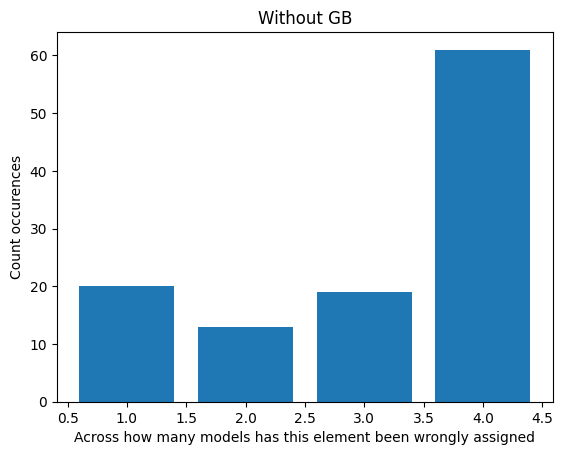

In [137]:
from collections import Counter

all_wrong_elements = list(wrong_fp_1) + list(wrong_fp_2) + list(wrong_fp_3) + list(wrong_fp_4)

counts_fp_without = Counter(all_wrong_elements)

counts2_without = Counter(dict(counts_fp_without).values())

keys = list(dict(counts2_without).keys())
values = list(dict(counts2_without).values())

plt.bar(keys, values)
plt.xlabel('Across how many models has this element been wrongly assigned')
plt.ylabel('Count occurences')
plt.title('Without GB')
plt.show()

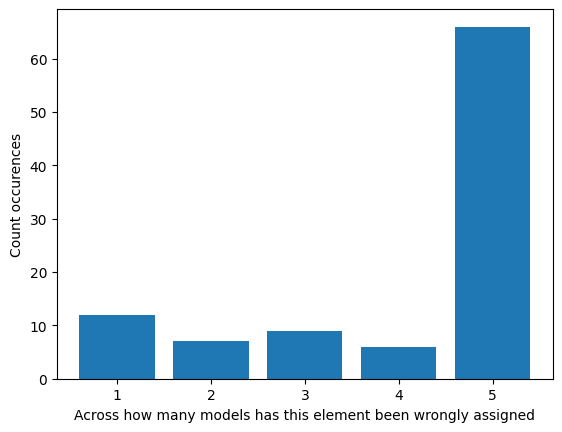

In [96]:
keys = list(dict(counts2).keys())
values = list(dict(counts2).values())

plt.bar(keys, values)
plt.xlabel('Across how many models has this element been wrongly assigned')
plt.ylabel('Count occurences')
plt.show()

In [ ]:
data_regression()

In [74]:
import itertools
mapp = {
    'top1': wrong_top1,
    'top2': wrong_top2,
    'top3': wrong_top3,
    'top4': wrong_top4,
    'top5': wrong_top5,
}
params = [wrong_top1, wrong_top2, wrong_top3, wrong_top4, wrong_top5]
for item in itertools.combinations(params, r=2):
    func_diff(item[0], item[1])

79
81
{420, 43, 526, 528, 720, 1079, 634}
{986, 552, 682, 909, 718, 433, 914, 1080, 1338}
79
83
{720, 634, 918, 526}
{986, 67, 552, 682, 718, 846, 914, 1338}
79
79
{420, 714, 43, 528, 720, 54, 1079, 634}
{1125, 486, 552, 970, 909, 846, 986, 30}
79
85
{714, 1036, 528, 720, 54, 1079, 438, 218}
{986, 486, 552, 746, 618, 1325, 718, 846, 914, 978, 788, 820, 1080, 1338}
81
83
{1080, 433, 909, 918}
{67, 420, 43, 846, 528, 1079}
81
79
{714, 682, 718, 433, 914, 54, 1080, 1338}
{1125, 486, 970, 846, 526, 30}
81
85
{714, 682, 1036, 909, 433, 54, 438, 218}
{420, 486, 746, 618, 43, 1325, 526, 846, 978, 788, 820, 634}
83
79
{67, 420, 682, 43, 714, 718, 528, 914, 54, 1079, 1338}
{1125, 486, 970, 909, 526, 918, 30}
83
85
{67, 682, 714, 1036, 528, 54, 1079, 438, 218}
{486, 618, 746, 1325, 526, 978, 788, 820, 918, 1080, 634}
79
85
{1125, 970, 1036, 909, 438, 218, 30}
{420, 618, 43, 746, 1325, 718, 1338, 914, 978, 788, 820, 1080, 634}


In [95]:
import matplotlib.pyplot as plt
from sklearn import tree

In [33]:
top_1_cls.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1675661428)

In [36]:
y_train_desc_classification

209      True
613      True
1131    False
140     False
1094    False
        ...  
1130    False
1294    False
860     False
1459    False
1126    False
Name: Target, Length: 1063, dtype: bool

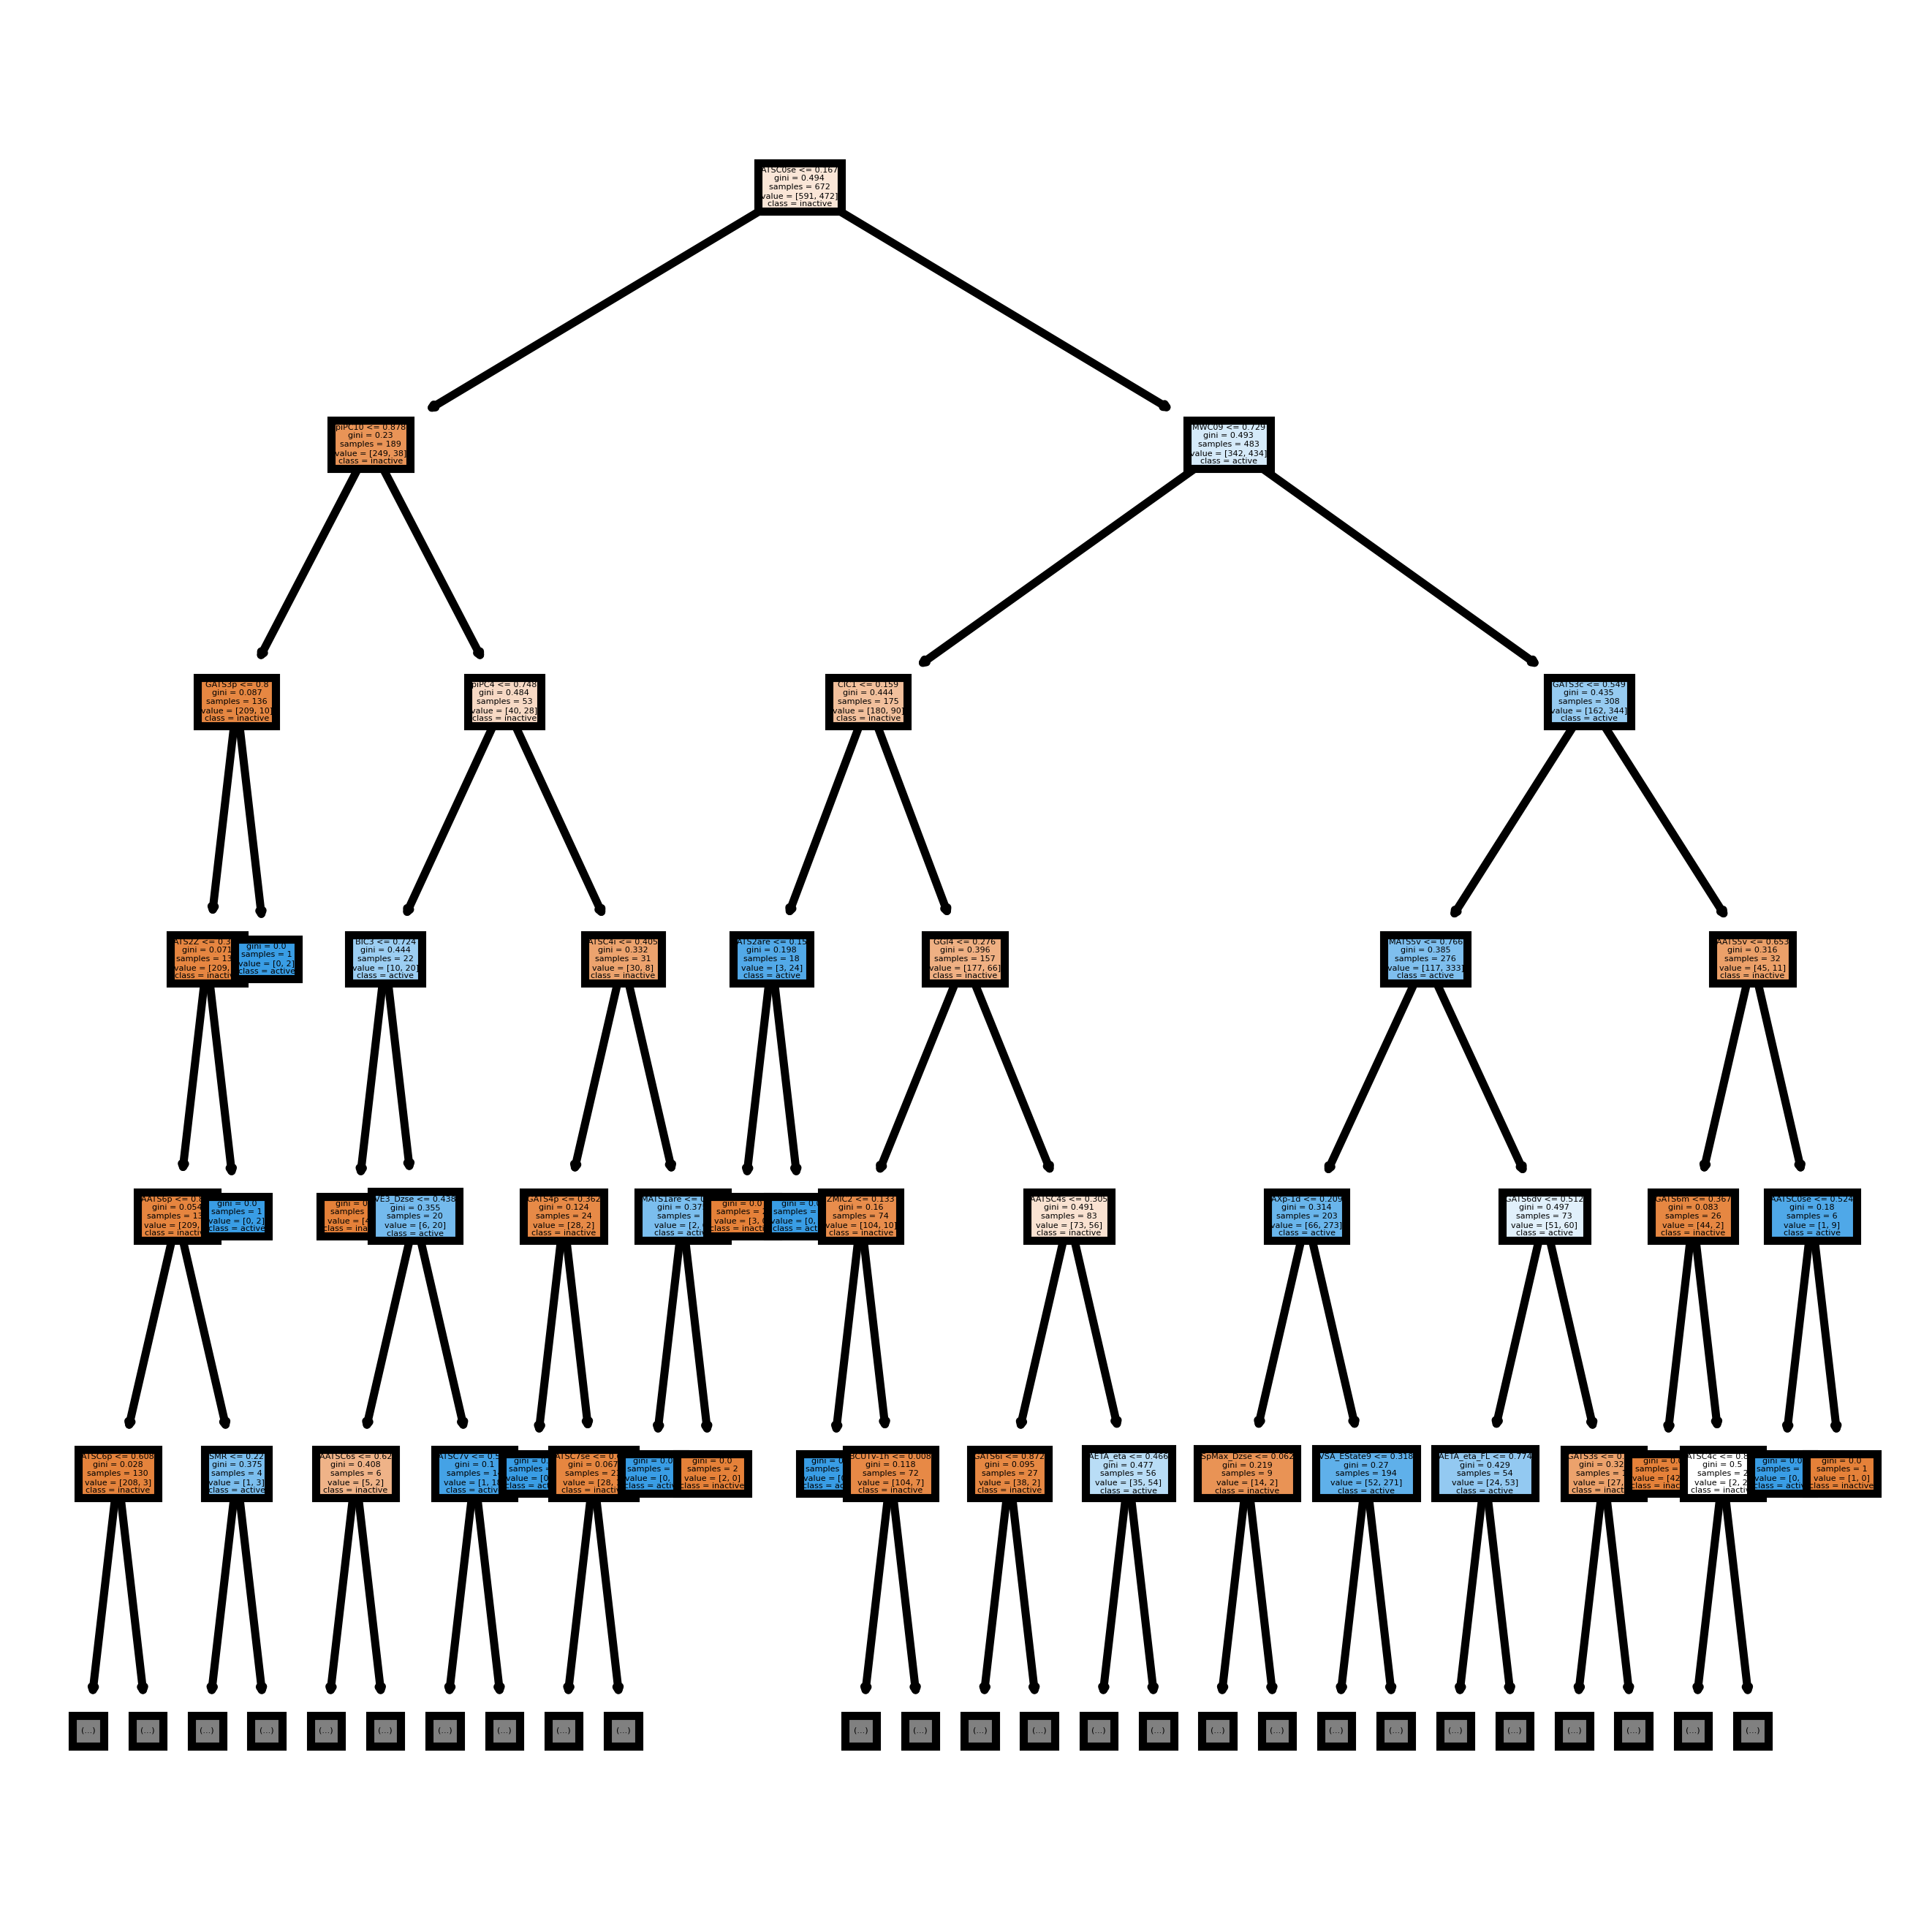

In [37]:
fn=list(X_train_desc_classification.columns)
cn=["inactive", "active"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(decision_tree=top_1_cls.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True,
               max_depth=5);
fig.savefig('rf_individualtree.png')

In [49]:
cls_rep = classification_report(y_test_desc_classification, y_pred)

In [50]:
print(cls_rep)

              precision    recall  f1-score   support

       False       0.85      0.85      0.85       260
        True       0.80      0.80      0.80       196

    accuracy                           0.83       456
   macro avg       0.82      0.82      0.82       456
weighted avg       0.83      0.83      0.83       456



In [54]:
wrong_top1 = X_test_desc_classification[y_test_desc_classification != y_pred].index

In [175]:
from sklearn.metrics import mean_absolute_error
def func_model_reg(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = mean_absolute_error(y_test, y_pred)
    print(f"accuracy: {accuracy}")
    wrong_elements = X_test[abs(y_test - y_pred) > 0.7].index
    print(f"{len(list(wrong_elements))} / {len(y_test)}")
    print(list(wrong_elements))
    return wrong_elements, y_pred

In [176]:
reg_top1 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)
reg_top2 = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1)
reg_top3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
reg_top4 = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1)
reg_top5 = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=2)

In [177]:
wrong_fp_reg_1, y_pred_fp_reg_1 =  func_model_reg(reg_top1, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)

accuracy: 0.583348026181988
145 / 456
[1240, 1384, 175, 1472, 371, 1084, 453, 1074, 141, 1286, 1347, 1004, 123, 70, 907, 239, 1223, 1124, 1343, 339, 316, 764, 727, 1293, 1453, 1260, 303, 1272, 451, 426, 220, 29, 428, 65, 259, 247, 289, 1318, 59, 23, 416, 1054, 78, 1400, 244, 1415, 15, 261, 1375, 351, 799, 420, 43, 203, 101, 342, 1386, 1285, 892, 949, 677, 429, 394, 270, 350, 163, 1354, 1007, 332, 485, 1199, 1290, 1091, 198, 983, 218, 56, 1517, 1388, 1024, 869, 1448, 1303, 433, 438, 1179, 1073, 607, 1348, 1464, 208, 58, 1320, 1373, 552, 1474, 196, 1356, 843, 380, 411, 964, 1325, 847, 322, 1342, 1261, 221, 113, 18, 285, 1467, 31, 826, 188, 918, 1120, 83, 48, 1265, 1245, 528, 179, 1263, 425, 346, 715, 243, 1438, 308, 54, 940, 109, 464, 705, 100, 1299, 1393, 266, 997, 1237, 377, 1457, 744, 1418]


In [154]:
wrong_fp_reg_1 = func_model_reg(reg_top1, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)
wrong_fp_reg_2 = func_model_reg(reg_top2, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)
wrong_fp_reg_3 = func_model_reg(reg_top3, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)
wrong_fp_reg_4 = func_model_reg(reg_top4, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)
wrong_fp_reg_5 = func_model_reg(reg_top5, X_train_fp_regression, y_train_fp_regression, X_test_fp_regression, y_test_fp_regression)

accuracy: 0.5862521080187887
145 / 456
[1240, 1384, 1471, 1489, 1472, 371, 1084, 453, 1074, 141, 1286, 1347, 1004, 123, 70, 907, 239, 1223, 1124, 1343, 339, 316, 764, 727, 1293, 1453, 1260, 303, 1272, 451, 426, 220, 29, 428, 259, 247, 289, 1318, 59, 23, 416, 1054, 78, 1400, 244, 1415, 15, 261, 1375, 351, 799, 420, 43, 203, 101, 342, 1386, 1285, 892, 949, 677, 429, 394, 270, 350, 163, 1354, 1007, 332, 485, 1199, 1290, 1091, 198, 983, 218, 56, 1517, 1388, 1024, 869, 1448, 1303, 433, 438, 1179, 1073, 607, 1348, 1464, 208, 58, 1320, 1373, 552, 1474, 196, 1356, 843, 380, 411, 964, 1325, 847, 322, 1342, 1261, 221, 113, 18, 285, 1467, 31, 826, 188, 918, 1120, 83, 48, 1265, 1245, 528, 179, 1263, 425, 346, 715, 243, 1438, 308, 54, 940, 109, 464, 705, 100, 1299, 1393, 266, 997, 1237, 377, 1457, 744, 1418]
accuracy: 0.5515678214540313
129 / 456
[1240, 1384, 297, 175, 1472, 371, 1510, 1210, 1084, 453, 1074, 141, 1286, 1347, 1004, 123, 70, 907, 239, 1223, 1124, 1420, 316, 764, 1293, 1453, 1272, 451

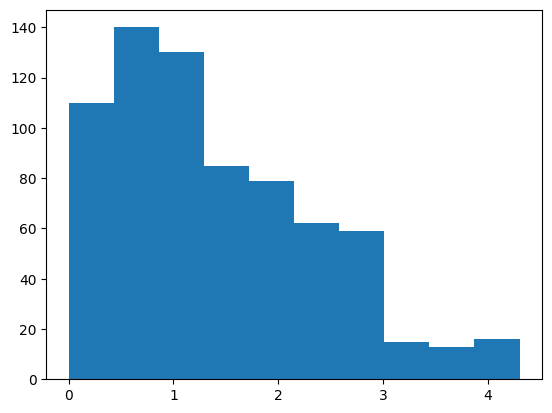

In [171]:
all_wrong_elements = list(wrong_fp_reg_1) + list(wrong_fp_reg_2) + list(wrong_fp_reg_3) + list(wrong_fp_reg_4) + list(wrong_fp_reg_5)


(n2, bins2, patches) = plt.hist(list(abs( 7 - data_regression.iloc[all_wrong_elements]['Target'])), bins=10)

In [181]:
data_regression.iloc[list(y_test_fp_regression.index)]

,smiles,pIC50,molecule_from_smiles,Target
231,COc1cccc(CN2CC(C(=O)NC(Cc3ccccc3)C(O)C[NH2+]Cc...,6.347753,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,6.347753
1240,CC(CC(O)C(COCc1cc(F)cc(F)c1)NC(=O)c1cc(C(=O)NC...,5.443697,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,5.443697
1384,CC1CC2(CC[NH+]1Cc1ccccc1)CNS(=O)(=O)N2c1cccc(F)c1,4.679854,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,4.679854
1471,CC(NC(=O)c1cc(N(C)S(C)(=O)=O)cc(S(=O)(=O)CCC([...,4.000000,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,4.000000
51,CN1C(=O)[C@@](c2ccncc2)(c2cccc(-c3cc(F)ccc3F)c...,7.698970,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,7.698970
...,...,...,...,...
355,CCc1cn2c3c(cc(C(=O)NC(Cc4ccccc4)C(O)C[NH2+]C4C...,8.045757,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,8.045757
170,CN1C(=N)N[C@](C)([C@@H]2C[C@H]2c2ccccc2)CC1=O,4.744728,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,4.744728
1108,COc1ccc2c(c1)C1(COC(N)=N1)c1cc(-c3ccccc3)ccc1O2,5.928118,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,5.928118
617,CN1C(=O)C(c2ccncc2)(c2cccc(-c3cccc(F)c3F)c2)N=C1N,7.397940,<rdkit.Chem.rdchem.Mol object at 0x0000024E1E4...,7.397940


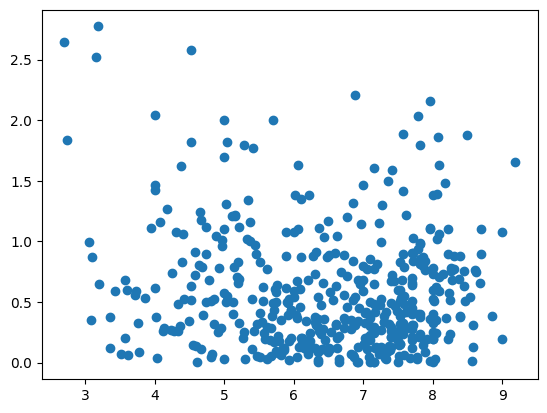

In [182]:
plt.scatter(data_regression.iloc[list(y_test_fp_regression.index)]['Target'], abs(data_regression.iloc[list(y_test_fp_regression.index)]['Target']-y_pred_fp_reg_1))
plt.show()

In [172]:
bins2

array([0.        , 0.43010299, 0.86020598, 1.29030897, 1.72041196,
       2.15051495, 2.58061794, 3.01072093, 3.44082392, 3.87092691,
       4.3010299 ])

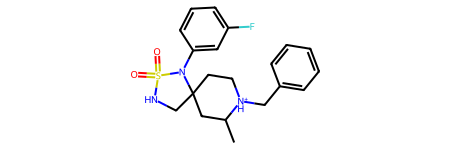

In [164]:
data_classification['molecule_from_smiles'].iloc[1384]

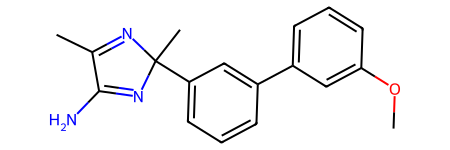

In [157]:
data_classification['molecule_from_smiles'].iloc[1239]

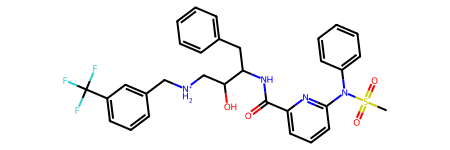

In [158]:
data_classification['molecule_from_smiles'].iloc[1241]